In [1]:
# Input info
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# barcodes_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/mincl.10_bothConds.False_p0.1/clones.dendro_dt_0.6__nuc.clust/"
clone_col = "den_clust"
f_name = "rmLowVars.0.2.clones_dendro.csv"
atac_col = "cluster_labels"

# config
input_cond = "Input"

# params
min_clone_size = 2
p_thresh = 0.1 
n_shuffle=1000
n_cpus = 8


# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/dendro_bc/results/noInput/knn/kparam_30"
# barcodes_dir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# N_DONORS = 2
# condition = "noInput" #"inputOnly" # noInput



se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_hg38_1_2/annotation_clones/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/dendro_bc/results/inputOnly/knn/kparam_30"
barcodes_dir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic"
N_DONORS = 5  
condition = "inputOnly"



In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 
import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

In [5]:
barcodes_in = {}
for d in np.arange(N_DONORS):
    barcodes_in[d] = pd.read_csv(join(barcodes_dir,f"donor{d}.{f_name}"), index_col=0)
    #barcodes_in[d] = str(d) + "_" + barcodes_in[str(d)]
    if clone_col not in barcodes_in[d].columns.values:
        barcodes_in[d][clone_col] = f"{d}_C0"
    else:
        barcodes_in[d][clone_col] = str(d) + "_" + barcodes_in[d][clone_col]
    
barcodes_in[d].head()

,size,donor,den_clust
lineage,,,
4_1,8,4,4_C1
4_3,7,4,4_C1
4_4,18,4,4_C1
4_5,17,4,4_C1
4_0,34,4,4_C2


## Load cells_meta

In [6]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]


## Map the new group to cells_meta

In [7]:
cells_meta[clone_col] = cells_meta.apply(lambda x: barcodes_in[int(x["donor"])].loc[x["name"], clone_col] , axis=1)

# Filter based on condition

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,den_clust
Input_AAACGAATCCCAGTAA-1,Input,2103,2103,30056.0,2764,124,63,832,22385,3888,...,2540,2215,AAACGAATCCCAGTAA-1_Input,Input_AAACGAATCCCAGTAA-1,25,0,Input,0_25,2,0_C2
Input_AAACGAATCGTGAACT-1,Input,5996,5996,66340.0,10716,362,165,2305,39978,12814,...,8689,5714,AAACGAATCGTGAACT-1_Input,Input_AAACGAATCGTGAACT-1,2,0,Input,0_2,4,0_C1
Input_AAACTCGAGGTACACG-1,Input,4901,4901,49202.0,9164,265,116,1810,27219,10628,...,6092,4446,AAACTCGAGGTACACG-1_Input,Input_AAACTCGAGGTACACG-1,4,0,Input,0_4,1,0_C1
Input_AAACTCGCAAGACACG-1,Input,3569,3569,45793.0,6391,211,100,1554,30248,7289,...,4404,3468,AAACTCGCAAGACACG-1_Input,Input_AAACTCGCAAGACACG-1,0,0,Input,0_0,0,0_C1
Input_AAACTCGCACTGTTAG-1,Input,1316,1316,62076.0,2215,76,153,1953,55119,2560,...,1918,1621,AAACTCGCACTGTTAG-1_Input,Input_AAACTCGCACTGTTAG-1,27,1,Input,1_27,10,1_C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Input_TTTGCGCCATTTGGCA-1,Input,2568,2568,32769.0,3923,151,62,1034,22409,5190,...,3564,2947,TTTGCGCCATTTGGCA-1_Input,Input_TTTGCGCCATTTGGCA-1,4,0,Input,0_4,6,0_C1
Input_TTTGGCCAGCGGACTA-1,Input,2428,2428,30485.0,5011,126,64,974,18625,5685,...,3912,3111,TTTGGCCAGCGGACTA-1_Input,Input_TTTGGCCAGCGGACTA-1,4,0,Input,0_4,6,0_C1
Input_TTTGGTTTCTATAGGC-1,Input,3729,3729,40121.0,5799,195,93,1278,25119,7637,...,4745,3686,TTTGGTTTCTATAGGC-1_Input,Input_TTTGGTTTCTATAGGC-1,0,0,Input,0_0,3,0_C1
Input_TTTGTGTAGTTTGGAA-1,Input,1331,1331,19626.0,1890,77,29,474,14588,2568,...,1789,1631,TTTGTGTAGTTTGGAA-1_Input,Input_TTTGTGTAGTTTGGAA-1,0,0,Input,0_0,6,0_C1


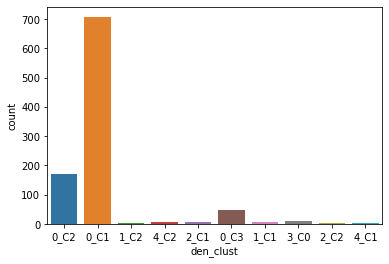

In [8]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
sns.countplot(data=cells_meta,x=clone_col)
cells_meta

## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 0
['0_C1' '0_C2' '0_C3']
[ 0  1  2  3  4  5  6  7  8 10 11 12 13]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (3, 13)


ic| 'clone min'


out_df    index variable  value      method
30  0_C1       11    0.0  global_all
36  0_C1       13    0.0  global_all
30  0_C1       11    0.0  global_min
36  0_C1       13    0.0  global_min
30  0_C1       11    0.0   clone_all
36  0_C1       13    0.0   clone_all
30  0_C1       11    0.0   clone_min
36  0_C1       13    0.0   clone_min
donor 1
['1_C1' '1_C2']
[ 0  2  4  5 10]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (2, 5)


ic| 'clone min'


out_df   index variable  value      method
2  1_C1        2    0.0  global_all
4  1_C1        4    0.0  global_all
7  1_C2        5    0.0  global_all
9  1_C2       10    0.0  global_all
2  1_C1        2    0.0  global_min
4  1_C1        4    0.0  global_min
7  1_C2        5    0.0  global_min
9  1_C2       10    0.0  global_min
2  1_C1        2    0.0   clone_all
4  1_C1        4    0.0   clone_all
7  1_C2        5    0.0   clone_all
9  1_C2       10    0.0   clone_all
2  1_C1        2    0.0   clone_min
4  1_C1        4    0.0   clone_min
7  1_C2        5    0.0   clone_min
9  1_C2       10    0.0   clone_min
donor 2
['2_C1' '2_C2']
[ 0  2  3 10]
Running hypergeo and saving sig results
plotting counts


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)
ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (2, 4)


ic| 'clone min'


out_df   index variable  value      method
0  2_C1        0    0.0  global_all
5  2_C2        3    0.0  global_all
6  2_C1       10    0.0  global_all
0  2_C1        0    0.0  global_min
5  2_C2        3    0.0  global_min
6  2_C1       10    0.0  global_min
0  2_C1        0    0.0   clone_all
5  2_C2        3    0.0   clone_all
6  2_C1       10    0.0   clone_all
0  2_C1        0    0.0   clone_min
5  2_C2        3    0.0   clone_min
6  2_C1       10    0.0   clone_min
donor 3
['3_C0']
[ 2  5 11]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (1, 3)


ic| 'clone min'


out_df   index variable  value      method
0  3_C0        2    0.0  global_all
1  3_C0        5    0.0  global_all
2  3_C0       11    0.0  global_all
0  3_C0        2    0.0  global_min
1  3_C0        5    0.0  global_min
2  3_C0       11    0.0  global_min
0  3_C0        2    0.0   clone_all
1  3_C0        5    0.0   clone_all
2  3_C0       11    0.0   clone_all
0  3_C0        2    0.0   clone_min
1  3_C0        5    0.0   clone_min
2  3_C0       11    0.0   clone_min
donor 4
['4_C1' '4_C2']
[ 0  2  3 10]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'
ic| '

Number of groups below p-val significance: 0


clone all'


axs 1
bh shape (2, 4)


ic| 'clone min'


out_df   index variable  value      method
1  4_C2        0    0.0  global_all
5  4_C2        3    0.0  global_all
1  4_C2        0    0.0  global_min
5  4_C2        3    0.0  global_min
1  4_C2        0    0.0   clone_all
5  4_C2        3    0.0   clone_all
1  4_C2        0    0.0   clone_min
5  4_C2        3    0.0   clone_min


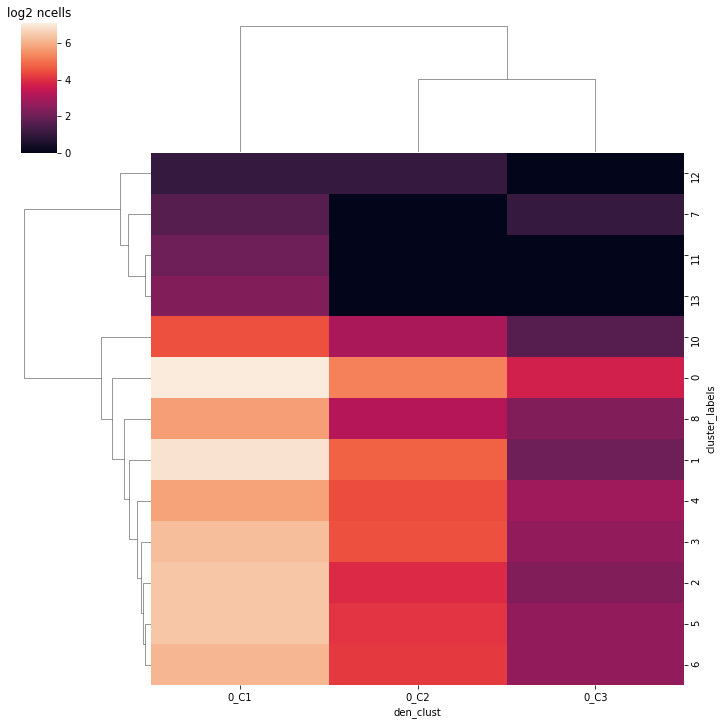

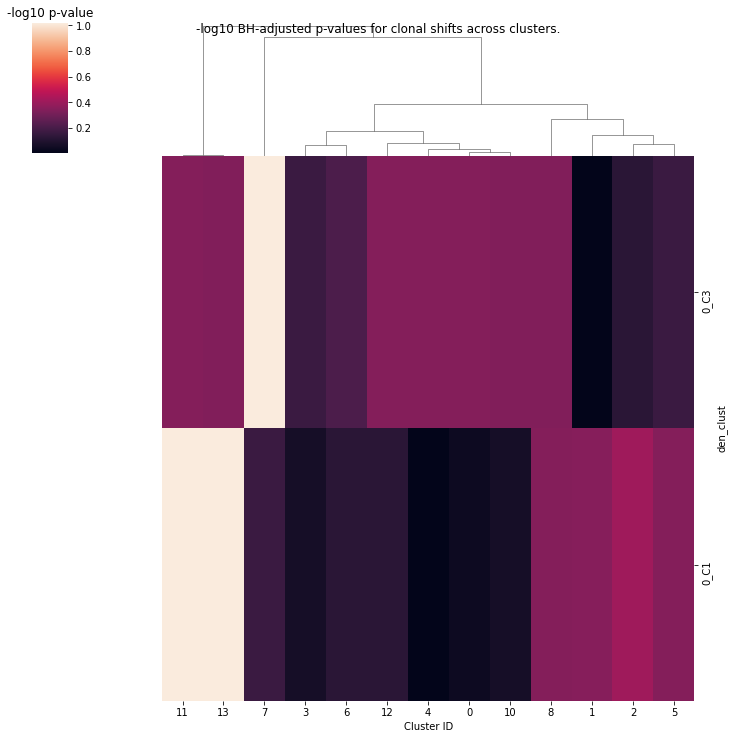

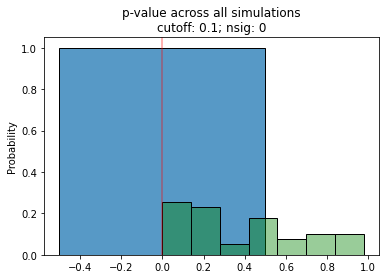

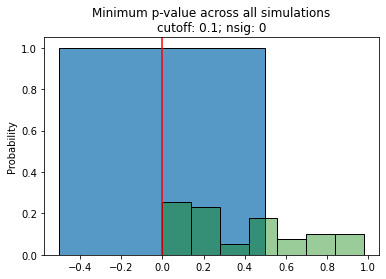

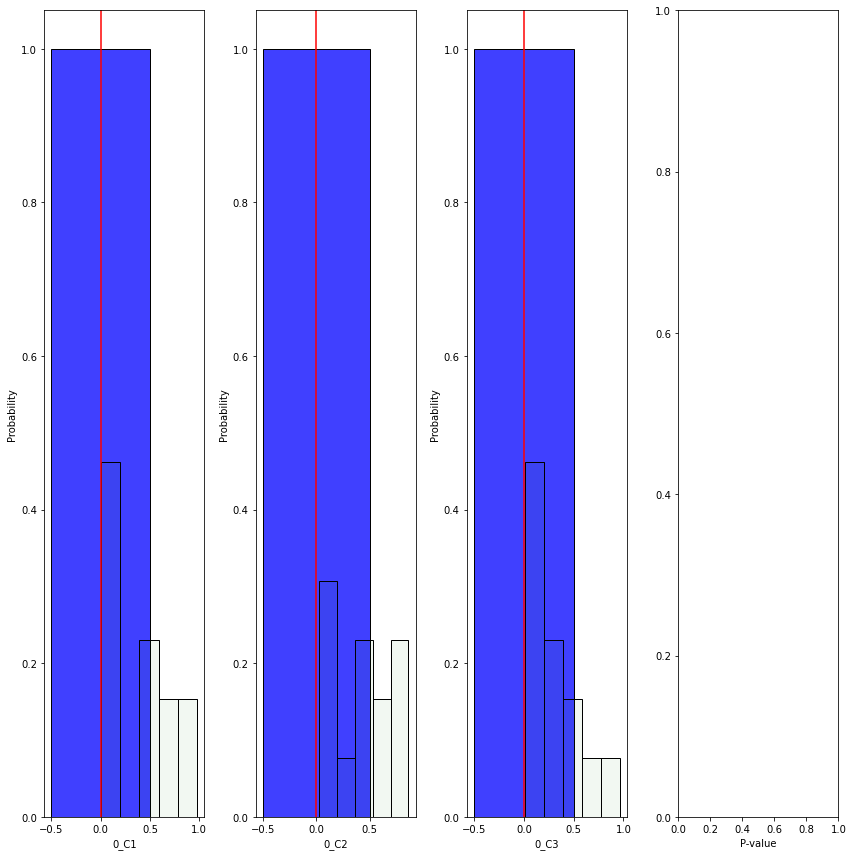

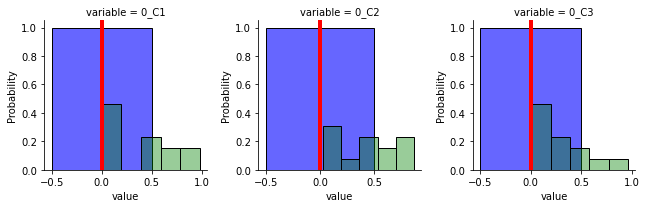

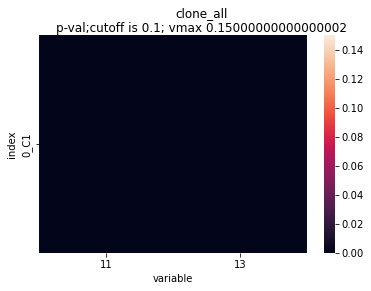

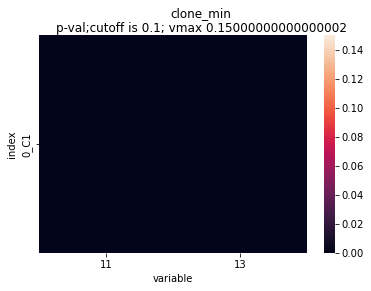

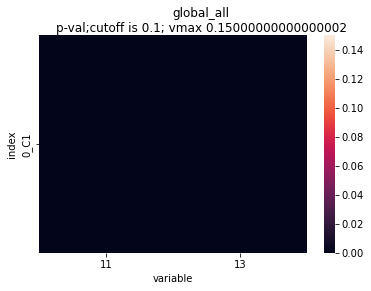

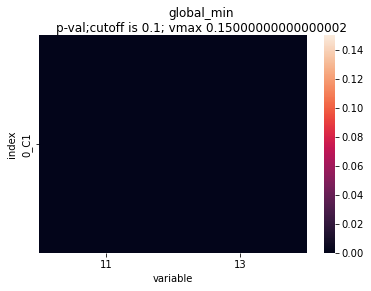

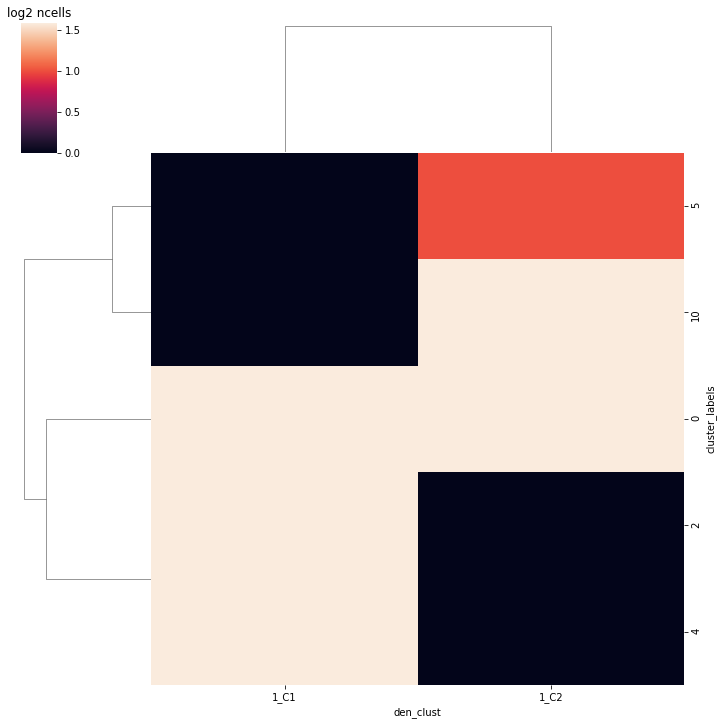

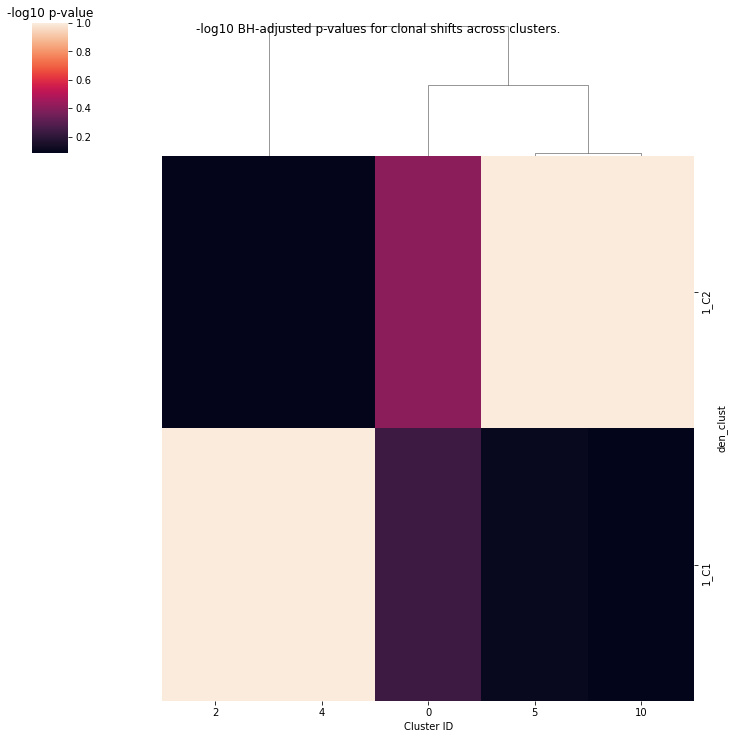

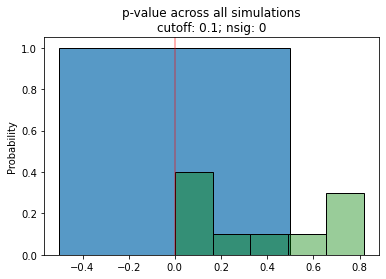

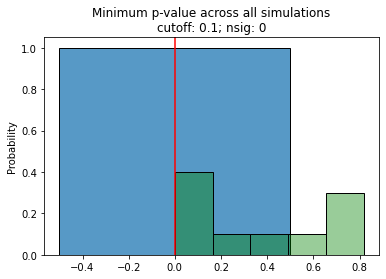

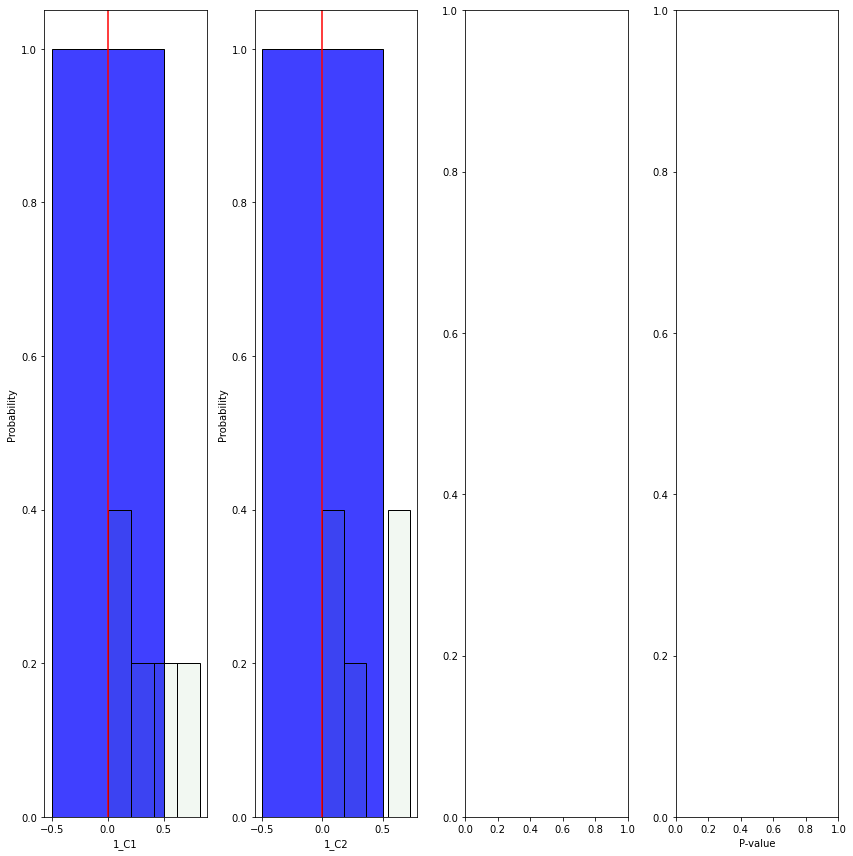

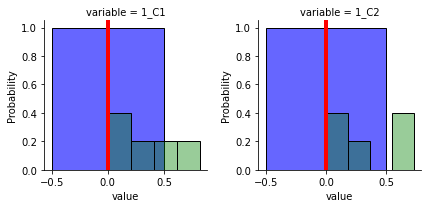

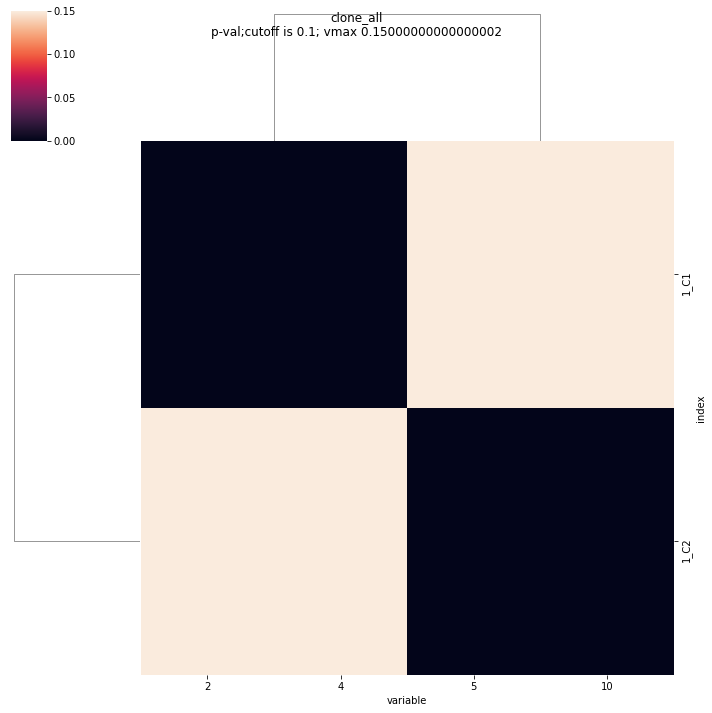

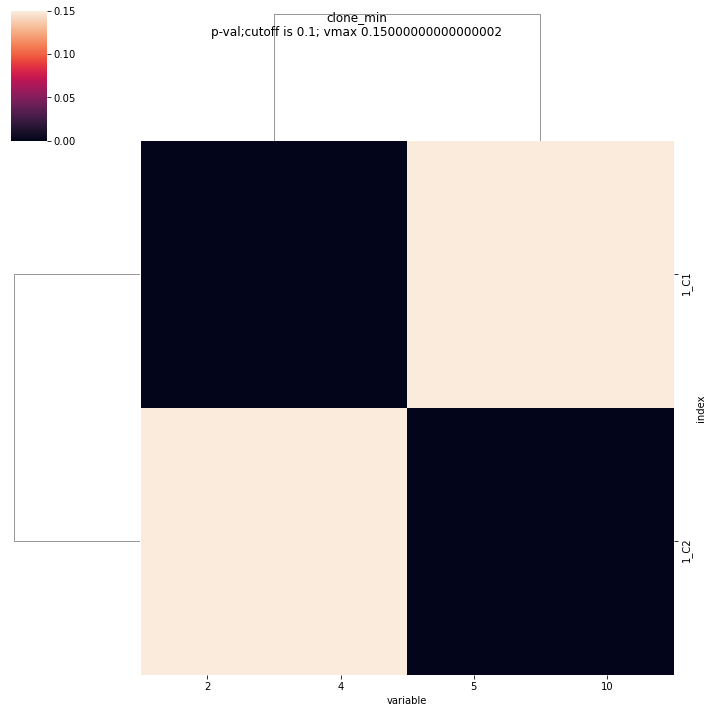

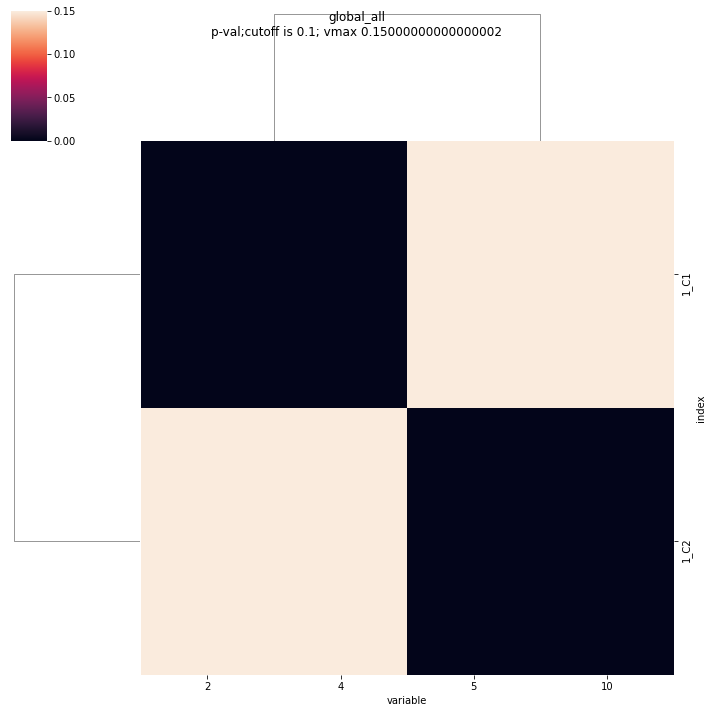

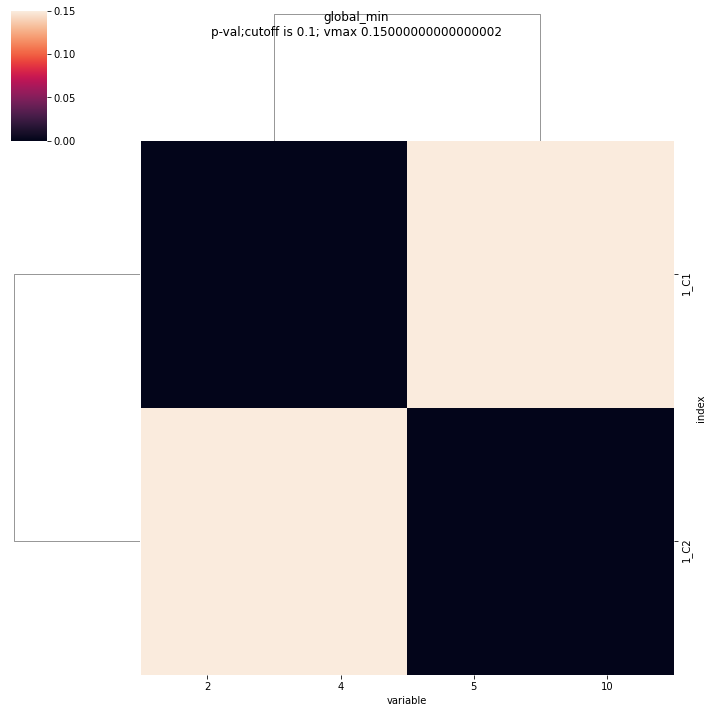

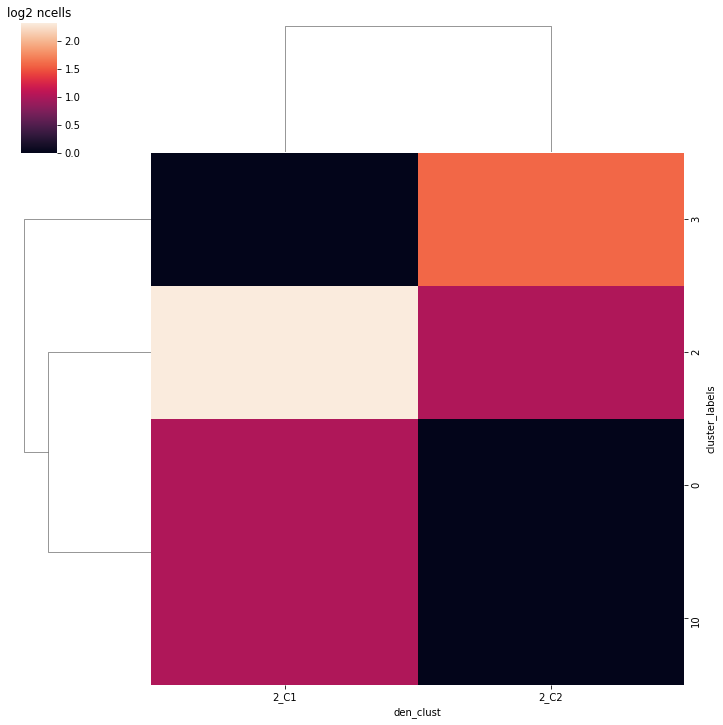

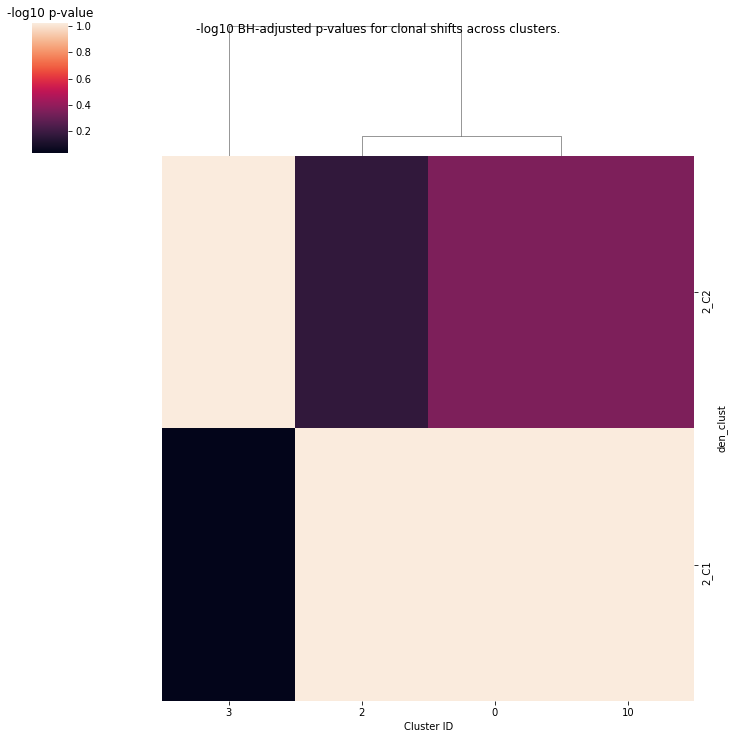

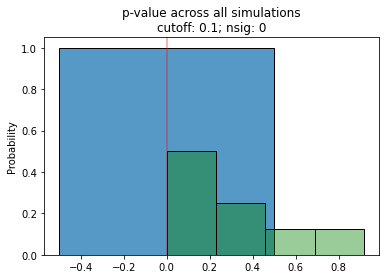

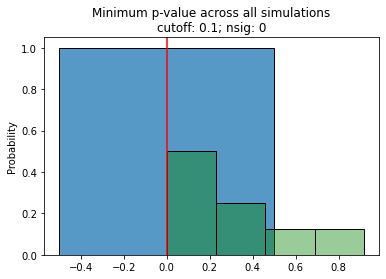

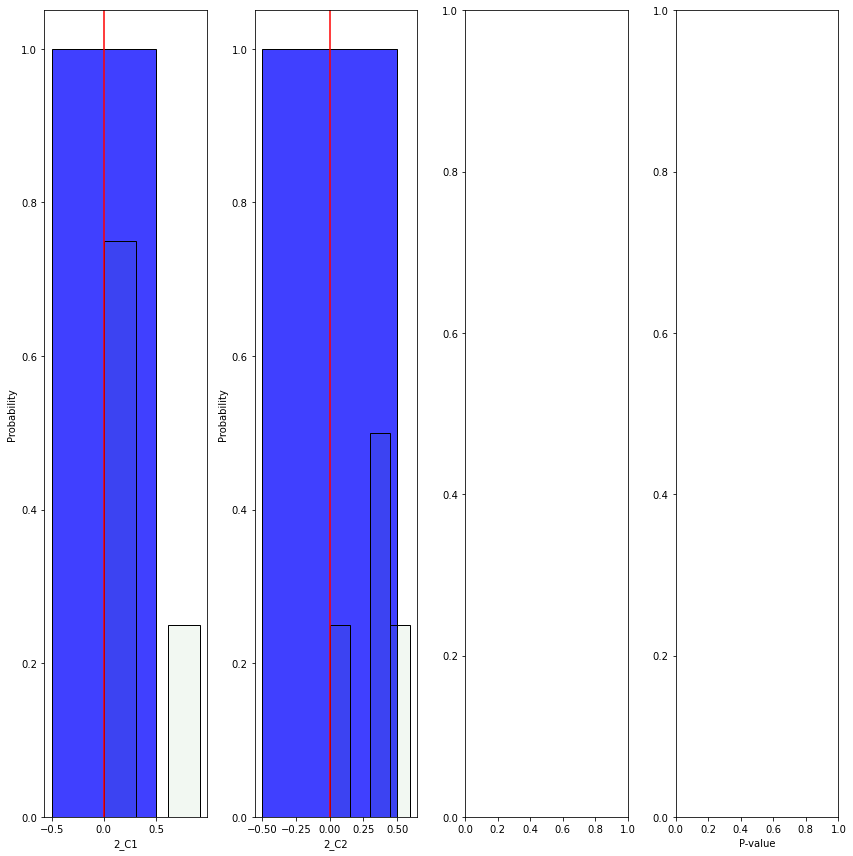

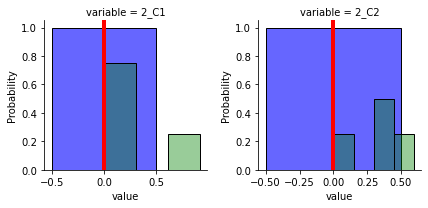

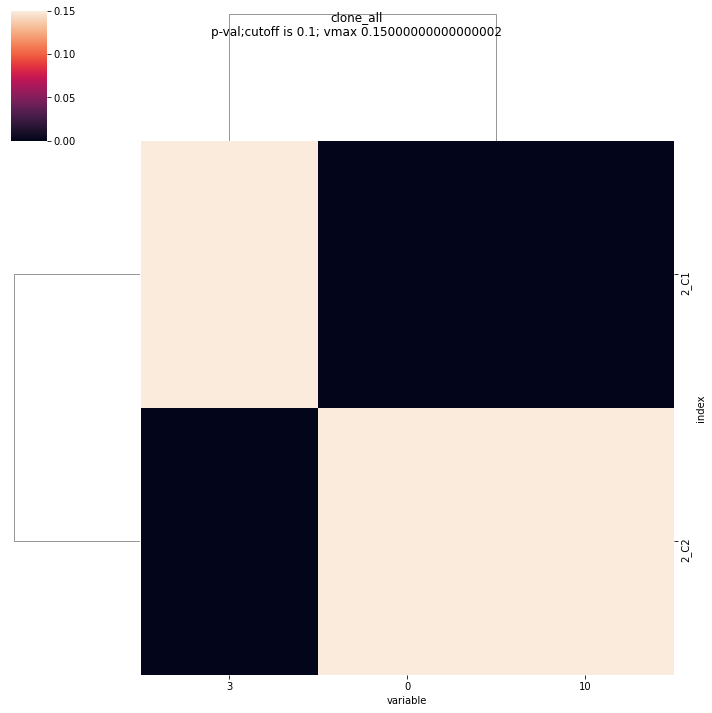

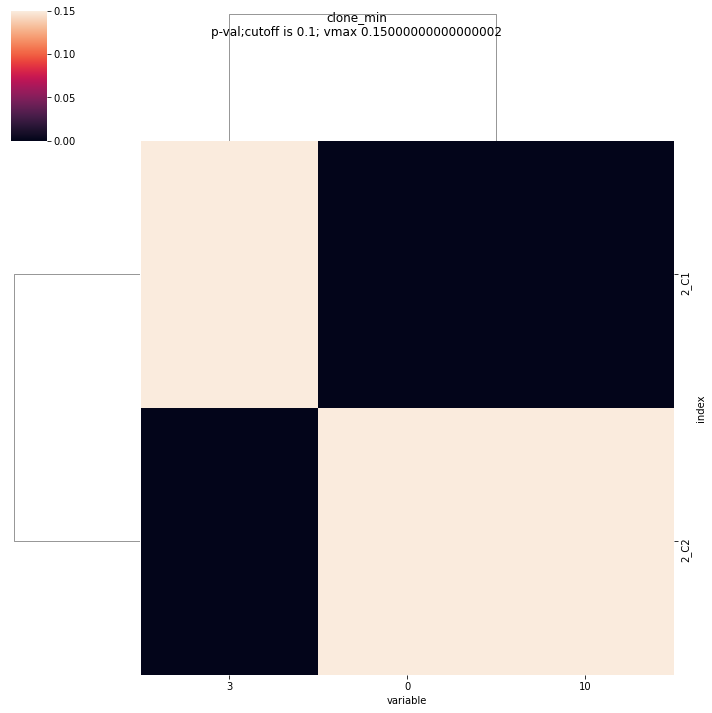

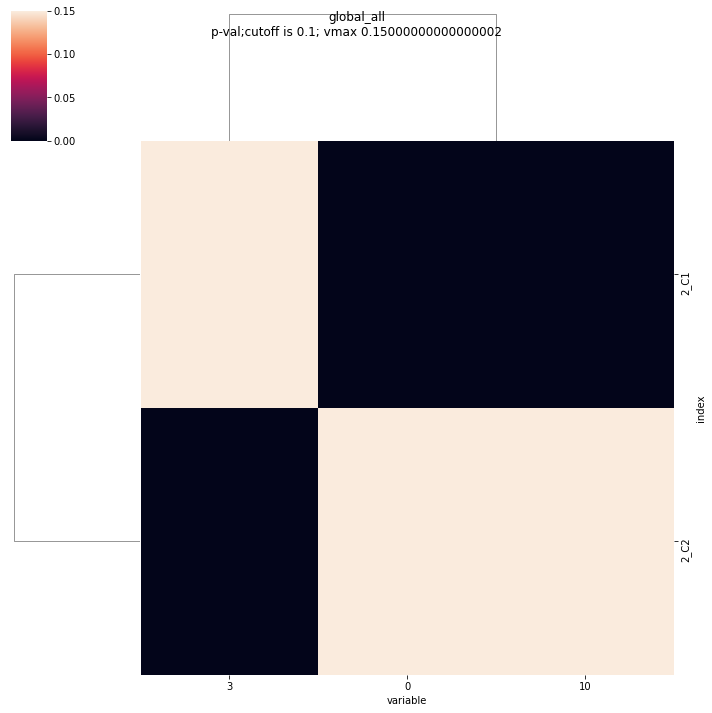

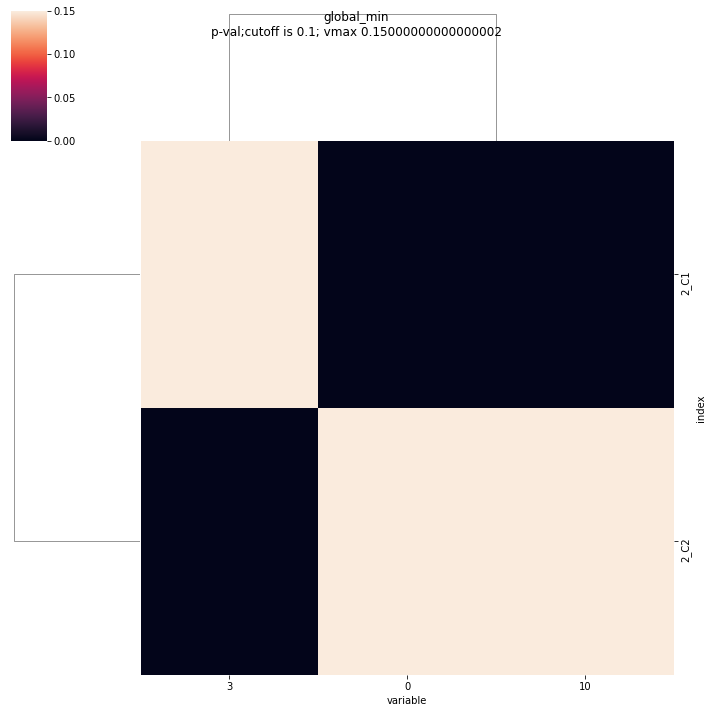

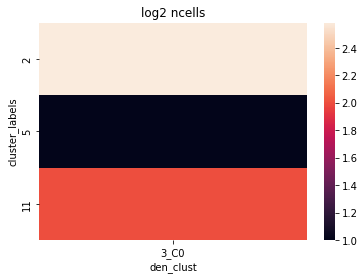

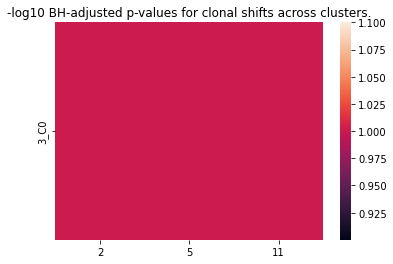

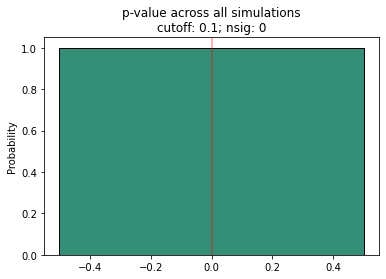

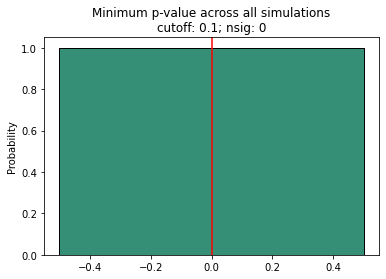

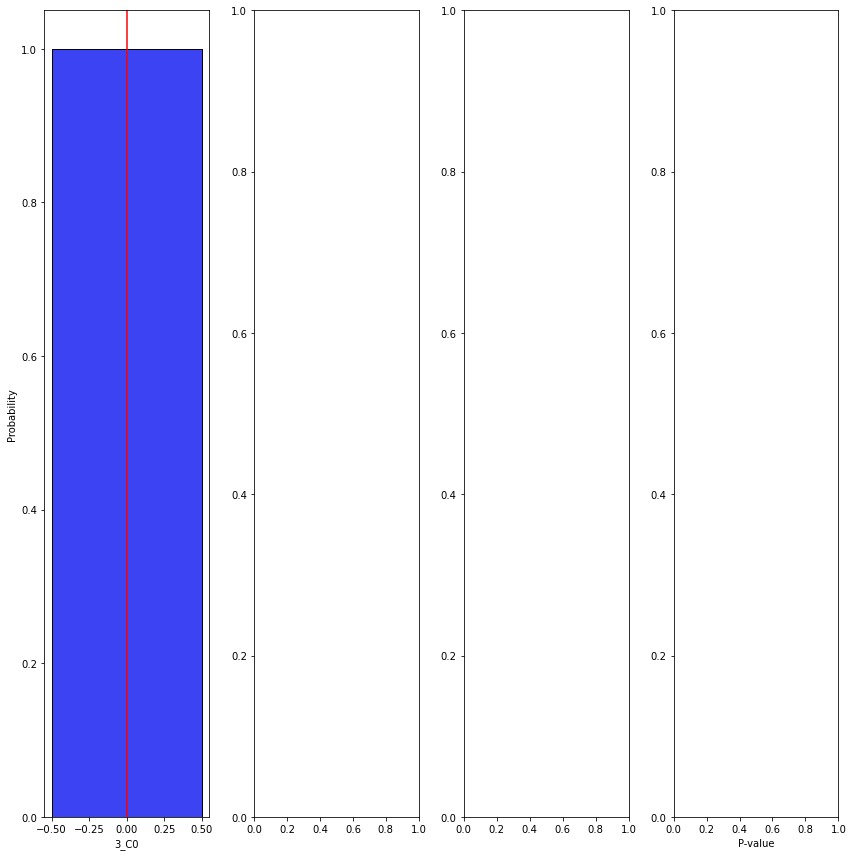

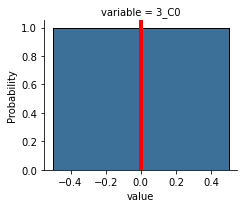

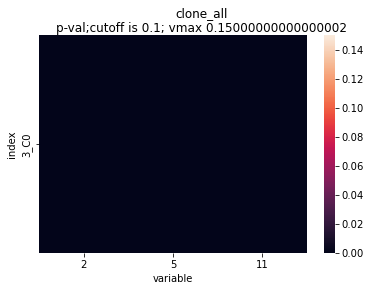

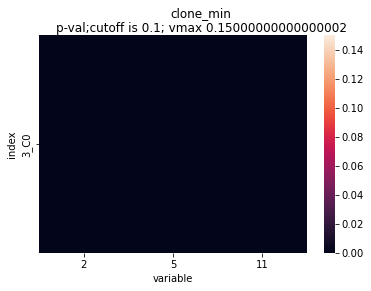

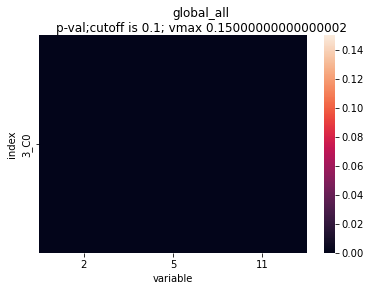

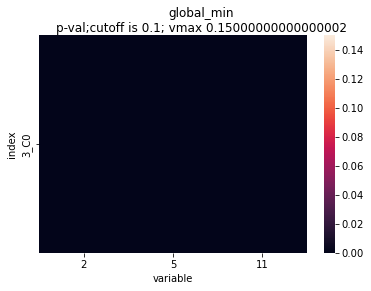

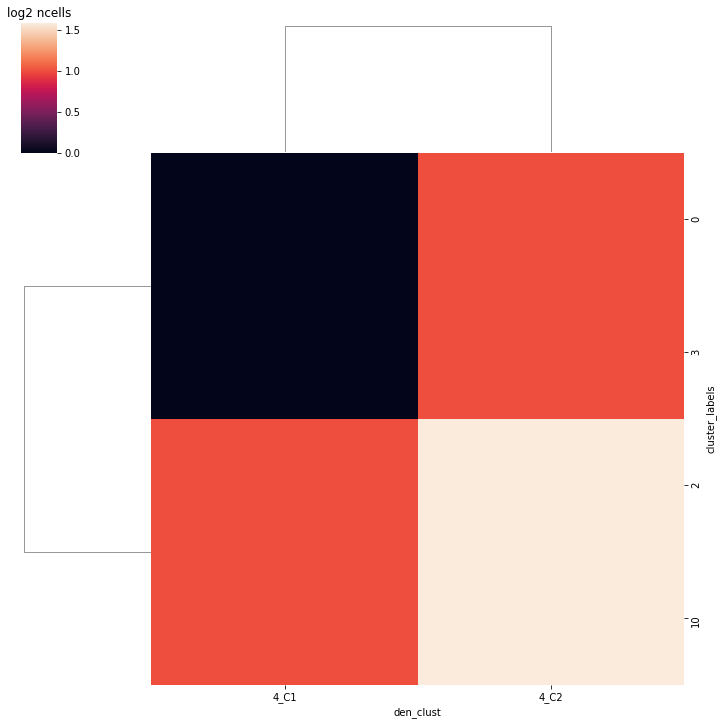

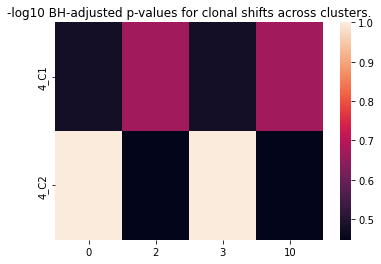

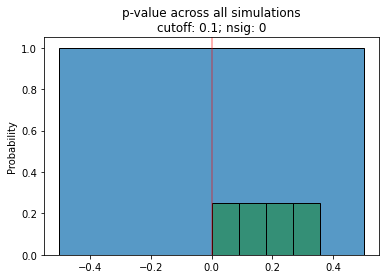

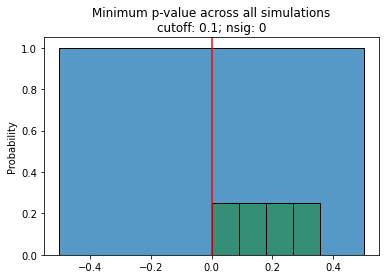

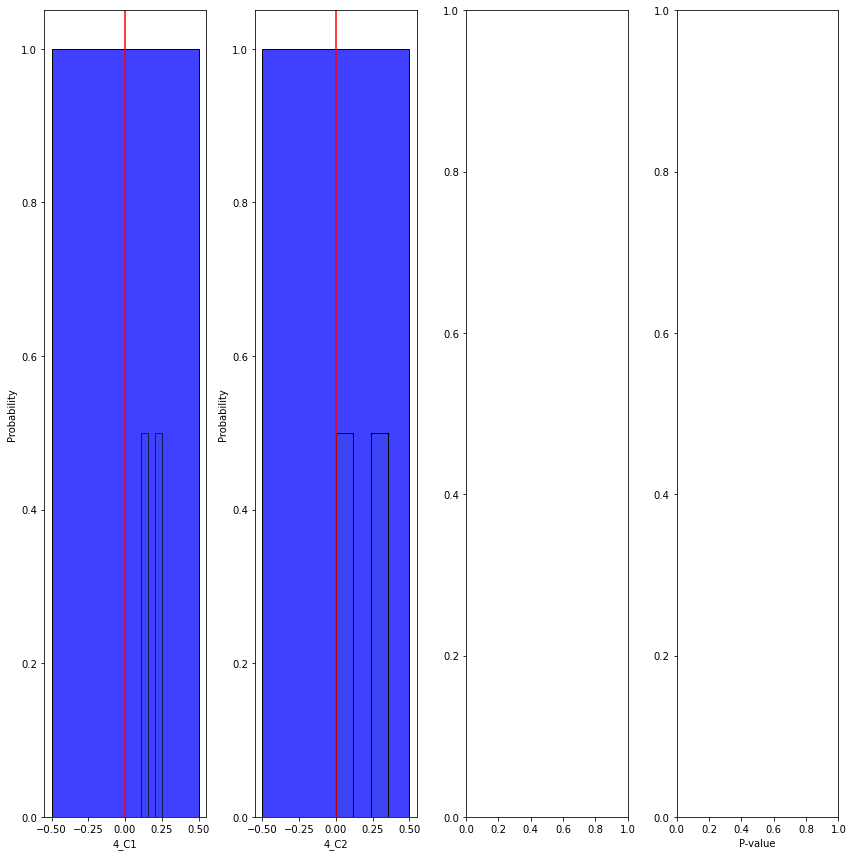

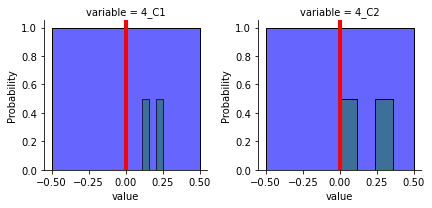

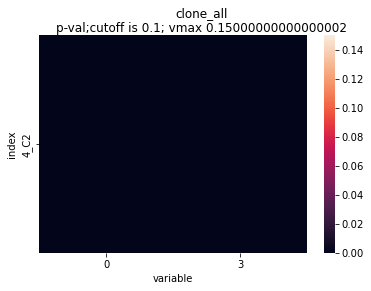

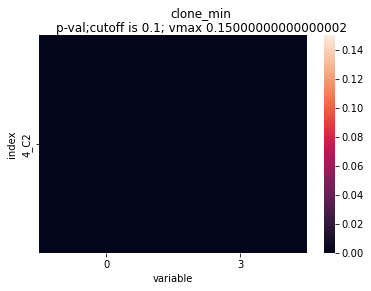

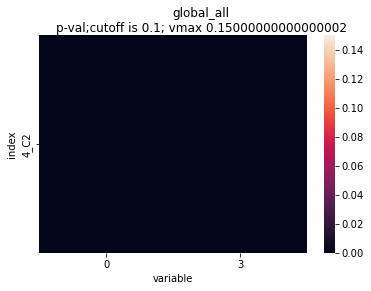

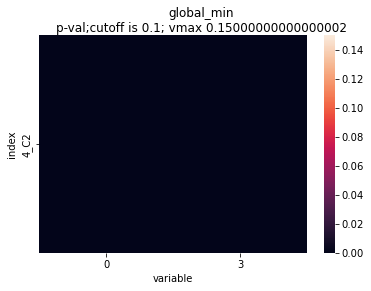

In [9]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)
    
    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)
#     #cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes)

#     curr_don_out = donor_out[int(d)]
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    
#     # plot just the counts
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
    

## B) Run using all donors as background

Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 3
bh shape (9, 13)


ic| 'clone min'


out_df     index variable  value      method
108  0_C1       13    0.0  global_all
108  0_C1       13    0.0  global_min
108  0_C1       13    0.0   clone_all
108  0_C1       13    0.0   clone_min


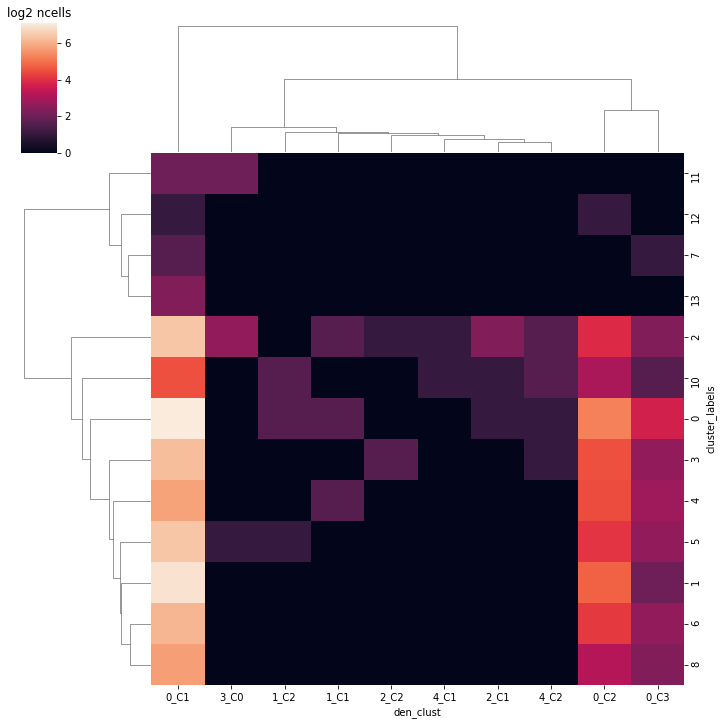

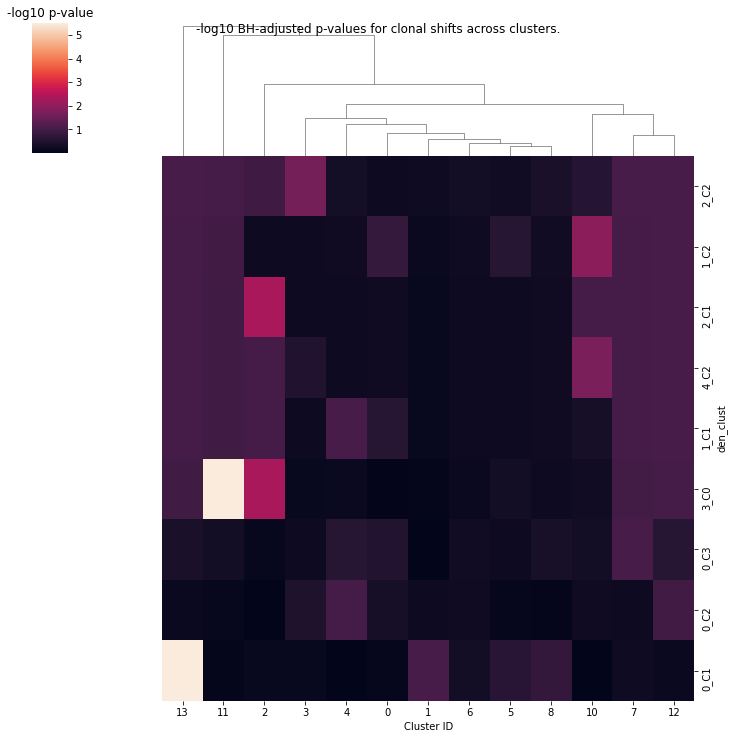

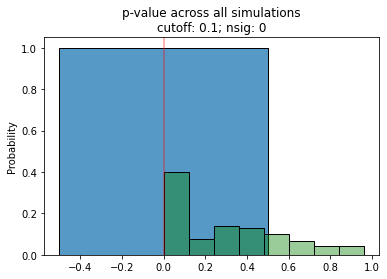

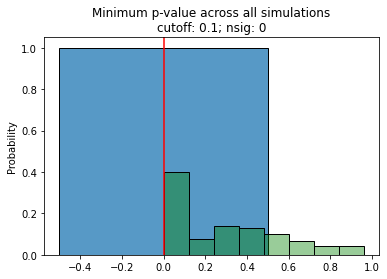

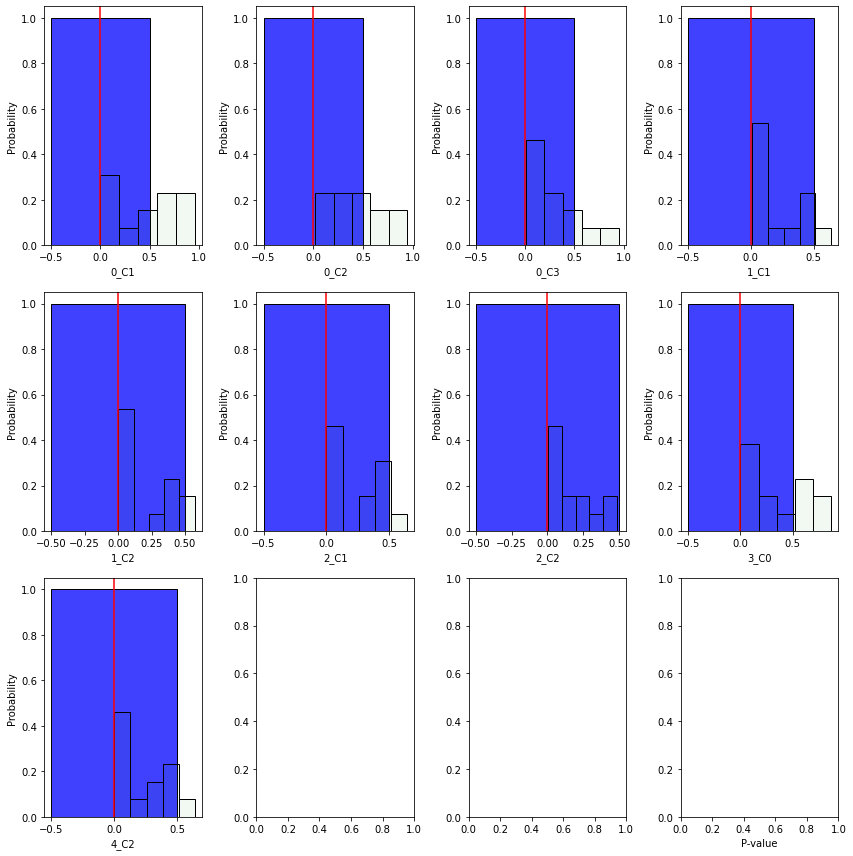

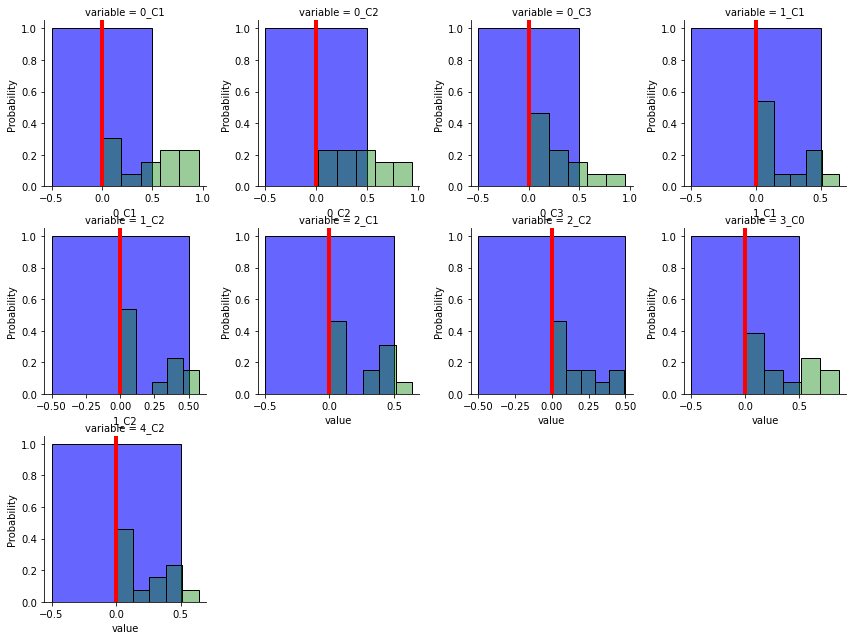

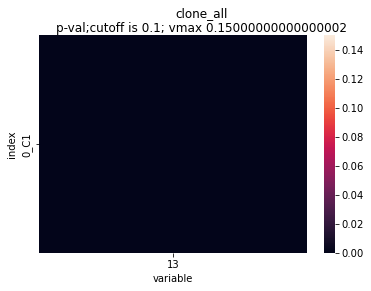

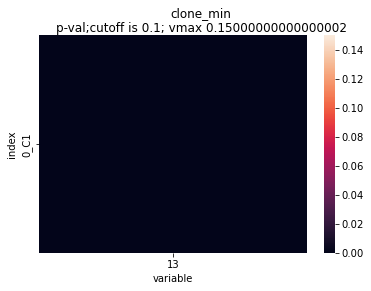

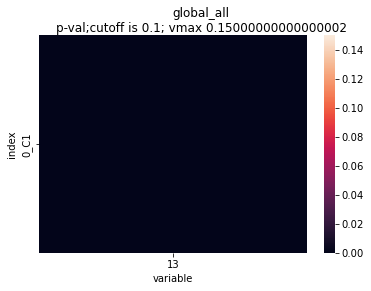

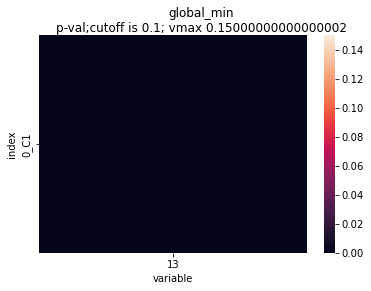

In [10]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)

# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_input_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_input_padjusted_sigOnly.csv"))
    
# g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                row_cluster=False)

# g.ax_heatmap.set(xlabel="Cluster ID")
# g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_input_padjusted_sigOnly.png"))



# ## Run shuffle
# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                      outdir=sim_all_dir)

In [11]:
out_df

,index,variable,value,method
108,0_C1,13,0.0,clone_all
108,0_C1,13,0.0,clone_min
108,0_C1,13,0.0,global_all
108,0_C1,13,0.0,global_min


In [12]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=0.05)
#     plt.suptitle(ind)